In [64]:
import cv2 as cv
from IPython.core.interactiveshell import InteractiveShell
from markdown import Markdown
from marker.config.parser import ConfigParser
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered
import numpy as np
import openai
import pandas as pd
from pydantic import BaseModel, Field
from rapidfuzz import fuzz
import tqdm
import matplotlib.pyplot as plt
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


import asyncio
import csv
import io
import json
import os
import re
import textwrap
from typing import List, Optional, Tuple, Union, Literal
import glob

In [4]:
# Configure Jupyter to display all output lines
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df_subset = pd.read_parquet(f"../data_temp/04 subset.parquet")
df_subset_filtered = df_subset[df_subset["is_in_questions"]==True]
pdf_name_i = df_subset_filtered["sha1"].iloc[0] + ".pdf"
output_path = f"../data_in/temp/md/{pdf_name_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text = f.read()

'../data_in/temp/md/0279901b645e568591ad95dac2c2bf939ef0c00d.pdf.md'

In [7]:
def find_pages_with_pattern(text, pattern):
    """
    Find pages in a document that contain a specific pattern.
    
    Args:
        text (str): The markdown text of the document
        pattern (str): The regex pattern to search for
        
    Returns:
        list: Page numbers containing the pattern
    """
    # Find page markers in the text
    page_markers = re.finditer(r"\{(\d+)\}-{48,}", text)
    page_numbers = []
    page_starts = []

    # Collect all page numbers and their starting positions
    for match in page_markers:
        page_numbers.append(int(match.group(1)))
        page_starts.append(match.start())

    # Add the end of the document as the last position
    page_starts.append(len(text))

    # Find pages containing the pattern
    matching_pages = []

    for i in range(len(page_numbers)):
        page_num = page_numbers[i]
        start_pos = page_starts[i]
        end_pos = page_starts[i+1] if i+1 < len(page_starts) else len(text)
        
        # Extract the page content
        page_content = text[start_pos:end_pos]
        
        # Check if the page contains the target pattern (case insensitive)
        if re.search(pattern, page_content, re.IGNORECASE):
            matching_pages.append(page_num)

    return matching_pages

# Find pages containing "Balance Sheet" or "Balance Sheets"
balance_sheet_pages = find_pages_with_pattern(text, r"balance sheet(s)?")
print(f"Pages containing 'Balance Sheet' or 'Balance Sheets': {balance_sheet_pages}")

Pages containing 'Balance Sheet' or 'Balance Sheets': [33, 56, 58, 62, 64, 68, 75, 82, 84, 85, 88, 89, 91, 92, 102, 103, 104, 105, 107, 109, 113, 114, 117, 119, 131, 136, 137, 138, 139, 140, 141, 142]


In [9]:
def count_numbers_on_page(text, filter_pages=None):
    """
    Count the number of numeric values on each page of the document.
    
    Args:
        text (str): The markdown text of the document
        filter_pages (list, optional): List of specific page numbers to analyze. If None, all pages are analyzed.
        
    Returns:
        dict: Dictionary mapping page numbers to the count of numbers found on that page
    """
    # Find page markers in the text
    page_markers = re.finditer(r"\{(\d+)\}-{48,}", text)
    page_numbers = []
    page_starts = []

    # Collect all page numbers and their starting positions
    for match in page_markers:
        page_numbers.append(int(match.group(1)))
        page_starts.append(match.start())

    # Add the end of the document as the last position
    page_starts.append(len(text))

    # Pattern to match numbers in various formats:
    # - Regular integers: 123, 456
    # - Numbers with commas: 1,234,567
    # - Numbers with dots as decimal separators: 123.45
    # - Numbers with spaces as thousand separators: 1 234 567
    number_pattern = r'(?<!\w)(?:(?:\d{1,3}(?:,\d{3})+|\d{1,3}(?:\s\d{3})+|\d+(?:\.\d+)?))(?!\w)'
    
    # Count numbers on each page
    page_number_counts = {}

    for i in range(len(page_numbers)):
        page_num = page_numbers[i]
        
        # Skip pages not in filter_pages if filter is provided
        if filter_pages is not None and page_num not in filter_pages:
            continue
            
        start_pos = page_starts[i]
        end_pos = page_starts[i+1] if i+1 < len(page_starts) else len(text)
        
        # Extract the page content
        page_content = text[start_pos:end_pos]
        
        # Find all numbers on the page
        numbers_found = re.findall(number_pattern, page_content)
        
        # Store the count
        page_number_counts[page_num] = len(numbers_found)

    return page_number_counts

# Count numbers on each page
page_number_counts = count_numbers_on_page(text,balance_sheet_pages)

# Display results
print("Number of numeric values found on each page:")
for page_num in sorted(page_number_counts.keys()):
    print(f"Page {page_num}: {page_number_counts[page_num]} numbers")

# Find pages with the most numbers (potentially financial data pages)
sorted_pages = sorted(page_number_counts.items(), key=lambda x: x[1], reverse=True)
print("\nPages with the most numbers (top 5):")
for page_num, count in sorted_pages[:5]:
    print(f"Page {page_num}: {count} numbers")


Number of numeric values found on each page:
Page 33: 3 numbers
Page 56: 146 numbers
Page 58: 188 numbers
Page 62: 142 numbers
Page 64: 61 numbers
Page 68: 64 numbers
Page 75: 100 numbers
Page 82: 22 numbers
Page 84: 15 numbers
Page 85: 10 numbers
Page 88: 10 numbers
Page 89: 22 numbers
Page 91: 90 numbers
Page 92: 27 numbers
Page 102: 13 numbers
Page 103: 7 numbers
Page 104: 8 numbers
Page 105: 14 numbers
Page 107: 30 numbers
Page 109: 40 numbers
Page 113: 68 numbers
Page 114: 49 numbers
Page 117: 70 numbers
Page 119: 156 numbers
Page 131: 76 numbers
Page 136: 83 numbers
Page 137: 57 numbers
Page 138: 65 numbers
Page 139: 48 numbers
Page 140: 46 numbers
Page 141: 51 numbers
Page 142: 101 numbers

Pages with the most numbers (top 5):
Page 58: 188 numbers
Page 119: 156 numbers
Page 56: 146 numbers
Page 62: 142 numbers
Page 142: 101 numbers


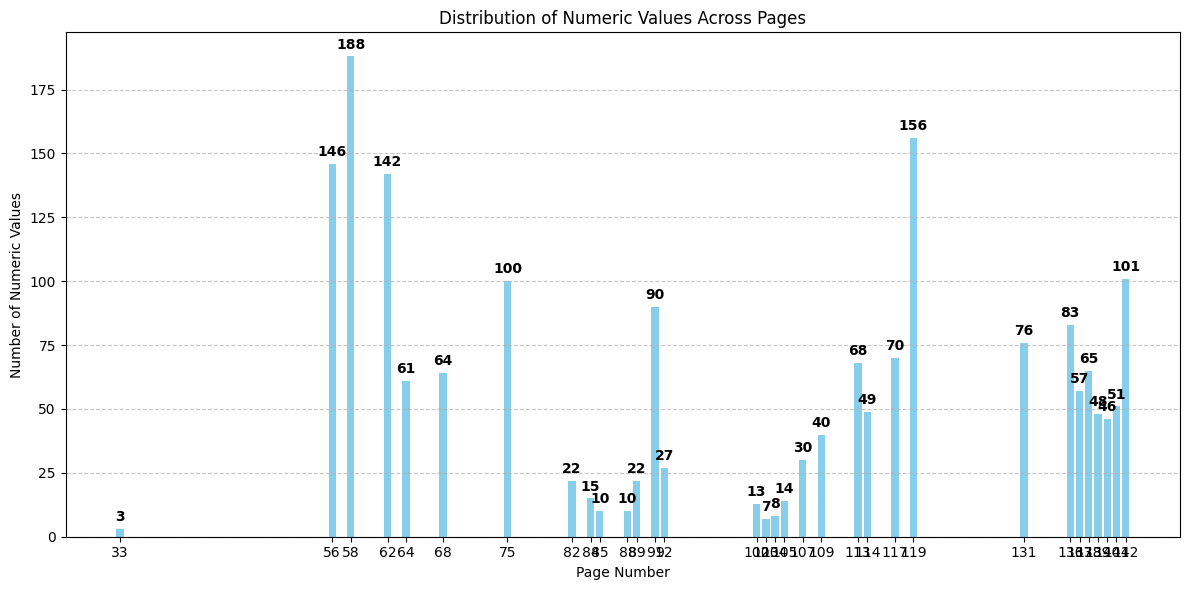

In [13]:
# Create a histogram of number counts per page

# Extract page numbers and counts for plotting
pages = [page for page, _ in sorted_pages]
counts = [count for _, count in sorted_pages]

_ = plt.figure(figsize=(12, 6))
_ = plt.bar(pages, counts, color='skyblue')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Number of Numeric Values')
_ = plt.title('Distribution of Numeric Values Across Pages')
_ = plt.xticks(pages)
_ = plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    _ = plt.text(pages[i], count + max(counts)*0.01, str(count), 
             ha='center', va='bottom', fontweight='bold')

_ = plt.tight_layout()
_ = plt.show()


In [24]:
# Function to get text of a specific page
def get_page_text(text, page_number):
    """
    Extract text for a specified page number from the full document text.
    
    Args:
        text (str): The full document text
        page_number (int): The page number to extract
        
    Returns:
        str: The extracted text for the specified page
    """
    page_text = ""
    # Find the start and end of the page in the text
    page_marker = f"{{{page_number}}}------------------------------------------------"
    page_start = text.find(page_marker)
    if page_start != -1:
        page_start = page_start + len(page_marker)
        # Look for the next page marker or end of text
        next_page_marker = f"{{{page_number + 1}}}------------------------------------------------"
        next_page_start = text.find(next_page_marker, page_start)
        if next_page_start != -1:
            page_text = text[page_start:next_page_start]
        else:
            # If there's no next page, take all text until the end
            page_text = text[page_start:]
        return page_text
    else:
        return f"Page {page_number} is not found in the document."

# Example usage: Get text of page 91
page_91_text = get_page_text(text, 91)
print(page_91_text)




# **ACRES COMMERCIAL REALTY CORP. AND SUBSIDIARIES CONSOLIDATED BALANCE SHEETS (in thousands, except share and per share data)**

|                                                                                         |                 | December 31 |           |
|-----------------------------------------------------------------------------------------|-----------------|-------------|-----------|
|                                                                                         | 2022            |             | 2021      |
| (1)<br>ASSETS                                                                           |                 |             |           |
| Cash and cash equivalents                                                               | \$<br>66,232    | \$          | 35,500    |
| Restricted cash                                                                         | 38,579          |             | 248,431   |
| Accrued interest receivable                       

In [22]:
page_number = 91
page_marker = f"{{{page_number}}}------------------------------------------------"
text.find(page_marker)

461822

In [97]:
def split_pages_by_marker(text):
    """
    Split a document text into individual pages based on page markers.
    
    Args:
        text (str): The full document text
        
    Returns:
        list: A list of page texts in order of appearance
    """
    pages = []
    # Regular expression to find all page markers
    import re
    markers = re.finditer(r"\{(\d+)\}-{48}", text)
    
    # Get all marker positions and page numbers
    marker_positions = []
    for match in markers:
        page_num = int(match.group(1))
        start_pos = match.end()
        end_pos = match.start()
        marker_positions.append((page_num, start_pos, end_pos))
    
    # Sort marker positions by their position in the text
    marker_positions.sort(key=lambda x: x[1])
    
    # Extract text between markers
    for i in range(len(marker_positions)):
        _, start_pos, end_pos = marker_positions[i]
        if i < len(marker_positions) - 1:
            end_pos = marker_positions[i+1][2]  # Subtract length of marker
            pages.append(text[start_pos:end_pos].strip())
        else:
            # Last page
            pages.append(text[start_pos:].strip())
    
    return pages

text_pages = split_pages_by_marker(text)


In [40]:
print(text_pages[91])

# **ACRES COMMERCIAL REALTY CORP. AND SUBSIDIARIES CONSOLIDATED BALANCE SHEETS (in thousands, except share and per share data)**

|                                                                                         |                 | December 31 |           |
|-----------------------------------------------------------------------------------------|-----------------|-------------|-----------|
|                                                                                         | 2022            |             | 2021      |
| (1)<br>ASSETS                                                                           |                 |             |           |
| Cash and cash equivalents                                                               | \$<br>66,232    | \$          | 35,500    |
| Restricted cash                                                                         | 38,579          |             | 248,431   |
| Accrued interest receivable                         

In [61]:


# Download necessary NLTK data (uncomment if not already downloaded)
# nltk.download('punkt')

def preprocess_text(text):
    """
    Preprocess text for TF-IDF analysis by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Removing numbers
    4. Removing extra whitespace
    5. Removing markdown table characters
    6. Tokenizing
    7. Stemming (optional)
    
    Args:
        text (str): The input text to preprocess
        
    Returns:
        str: Preprocessed text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove markdown table characters (|, -, +)
    text = re.sub(r'[\|\-\+]+', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Optional: Tokenize and stem
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    text = ' '.join(stemmed_tokens)
    
    return text

# # Apply preprocessing to all documents
# preprocessed_pages = [preprocess_text(doc) for doc in text_pages]

# # Create and apply TF-IDF vectorizer with preprocessed text
# preprocessed_vectorizer = TfidfVectorizer(stop_words='english')
# preprocessed_tfidf_matrix = preprocessed_vectorizer.fit_transform(preprocessed_pages)

# # Get feature names from preprocessed text
# preprocessed_feature_names = preprocessed_vectorizer.get_feature_names_out()


In [48]:
preprocessed_tfidf_matrix[91].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [45]:
preprocessed_feature_names

array(['aarul', 'abat', 'abil', ..., 'zero', 'zip', 'zone'], dtype=object)

In [59]:
text_pages


['![](_page_0_Picture_0.jpeg)\n\n# 2022 Annual Report\n\n{',
 '{',
 'Dear Fellow Shareholder,\n\nWe are pleased to provide you an update on the progress of your investments in ACRES Commercial Realty Corp. ("ACR" or the "Company"). During the past year, our manager has continued to make progress on the core tenets of its responsibilities to manage the existing assets in the portfolio, originate new loan assets, facilitate the financing of the assets, and control costs to drive earnings and increase book value per share. We are pleased to report that substantial progress has been made on all fronts and we remain focused on these mandates going forward.\n\nThe ACRES team continued to diligently manage our assets and provide exceptional service for our borrowers. We worked proactively with these borrowers to address their needs so that they could maintain payments on their loans. These efforts have resulted in a high-quality, stabilized book to build on.\n\nWe are proud of the success we 

In [57]:
# Define the path to the markdown files
path = "../data_in/temp/EnterpriseRAG_2025_02_markdown"

# Get all markdown files in the directory and subdirectories
md_files = glob.glob(os.path.join(path, "**/*.md"), recursive=True)

# Load the content of each markdown file into a list of strings
md_contents = []
for file_path in md_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        md_contents.append(file.read())

print(f"Loaded {len(md_contents)} markdown files")







Loaded 100 markdown files


In [58]:
md_files

['../data_in/temp/EnterpriseRAG_2025_02_markdown\\0279901b645e568591ad95dac2c2bf939ef0c00d\\0279901b645e568591ad95dac2c2bf939ef0c00d.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0981826b4b43a88920f3e01c71ae73539bab84cc\\0981826b4b43a88920f3e01c71ae73539bab84cc.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0a61a353b1ea9fd9b8f63b60239634ca3007d58f\\0a61a353b1ea9fd9b8f63b60239634ca3007d58f.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0c0faea14d108e1617f2d6d2a7c1aae04eb88fe0\\0c0faea14d108e1617f2d6d2a7c1aae04eb88fe0.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0f111d244aee3d976684995a222fa177a64571c4\\0f111d244aee3d976684995a222fa177a64571c4.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\105688726e097505beef4934896193ac51295037\\105688726e097505beef4934896193ac51295037.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\12bff07b957b1c8f8cad9d917ca18005720cce9b\\12bff07b957b1c8f8cad9d917ca18005720cce9b.md',
 '../data_in/temp/EnterpriseRAG_20

In [ ]:
# Initialize global lists to store all pages and page ranges
global_page_list = []
file_page_ranges = []


# Process each markdown file
for i, file_content in enumerate(md_contents):
    # Split the file content into pages
    pages = split_pages_by_marker(file_content)
    
    # Record the start and end indices in the global page list
    start_idx = len(global_page_list)
    
    # Add pages to the global page list
    global_page_list.extend(pages)
    
    # Record the page range for this file
    end_idx = len(global_page_list) - 1
    file_page_ranges.append({
        'file_path': md_files[i],
        'start_page': start_idx,
        'end_page': end_idx,
        'num_pages': len(pages)
    })

print(f"Total pages extracted: {len(global_page_list)}")
print(f"Files processed: {len(file_page_ranges)}")

Total pages extracted: 14454
Files processed: 100


In [66]:
# Apply preprocessing to all documents
preprocessed_pages = [preprocess_text(doc) for doc in global_page_list]

# Initialize the vectorizer
vectorizer = CountVectorizer()

# Learn the vocabulary dictionary
_ = vectorizer.fit(preprocessed_pages)

# Access the vocabulary dictionary
vocabulary = vectorizer.vocabulary_



CountVectorizer()

In [68]:

# # Save vocabulary to a JSON file

# # Create directory if it doesn't exist
# os.makedirs('../data_vocabulary', exist_ok=True)

# with open('../data_vocabulary/vocabulary.json', 'w') as f:
#     json.dump(vocabulary, f, indent=4)

# # Confirm file was saved
# print(f"Vocabulary saved to '../data_out/vocabulary.json' with {len(vocabulary)} terms")

Vocabulary saved to '../data_out/vocabulary.json' with 68792 terms


In [71]:
# Load vocabulary from file
with open('../data_vocabulary/vocabulary.json', 'r') as f:
    vocabulary = json.load(f)
print(f"Vocabulary loaded from '../data_vocabulary/vocabulary.json' with {len(vocabulary)} terms")
vocabulary

Vocabulary loaded from '../data_vocabulary/vocabulary.json' with 68792 terms


{'pagepicturejpeg': 47289,
 'annual': 4086,
 'report': 53126,
 'dear': 17338,
 'fellow': 23962,
 'sharehold': 56728,
 'we': 66518,
 'are': 4653,
 'pleas': 49145,
 'to': 62445,
 'provid': 50964,
 'you': 68468,
 'an': 3089,
 'updat': 64915,
 'on': 45601,
 'the': 61199,
 'progress': 50712,
 'of': 44664,
 'your': 68480,
 'invest': 34047,
 'in': 32162,
 'acr': 1051,
 'commerci': 14271,
 'realti': 52109,
 'corp': 15676,
 'or': 46261,
 'compani': 14492,
 'dure': 19728,
 'past': 47678,
 'year': 68224,
 'our': 46787,
 'manag': 39265,
 'ha': 28781,
 'continu': 15352,
 'make': 39186,
 'core': 15631,
 'tenet': 60892,
 'it': 34589,
 'respons': 53469,
 'exist': 22808,
 'asset': 5106,
 'portfolio': 49465,
 'origin': 46483,
 'new': 42878,
 'loan': 38113,
 'facilit': 23234,
 'financ': 24499,
 'and': 3179,
 'control': 15466,
 'cost': 15790,
 'drive': 19515,
 'earn': 19936,
 'increas': 32813,
 'book': 9022,
 'valu': 65277,
 'per': 48251,
 'share': 56646,
 'that': 61132,
 'substanti': 59262,
 'been': 7487

In [72]:
# Create and apply TF-IDF vectorizer with preprocessed text
preprocessed_vectorizer = TfidfVectorizer(stop_words='english')
preprocessed_tfidf_matrix = preprocessed_vectorizer.fit_transform(preprocessed_pages)

# Get feature names from preprocessed text
preprocessed_feature_names = preprocessed_vectorizer.get_feature_names_out()

In [73]:
preprocessed_tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1896485 stored elements and shape (14454, 68578)>

In [74]:
md_files

['../data_in/temp/EnterpriseRAG_2025_02_markdown\\0279901b645e568591ad95dac2c2bf939ef0c00d\\0279901b645e568591ad95dac2c2bf939ef0c00d.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0981826b4b43a88920f3e01c71ae73539bab84cc\\0981826b4b43a88920f3e01c71ae73539bab84cc.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0a61a353b1ea9fd9b8f63b60239634ca3007d58f\\0a61a353b1ea9fd9b8f63b60239634ca3007d58f.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0c0faea14d108e1617f2d6d2a7c1aae04eb88fe0\\0c0faea14d108e1617f2d6d2a7c1aae04eb88fe0.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\0f111d244aee3d976684995a222fa177a64571c4\\0f111d244aee3d976684995a222fa177a64571c4.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\105688726e097505beef4934896193ac51295037\\105688726e097505beef4934896193ac51295037.md',
 '../data_in/temp/EnterpriseRAG_2025_02_markdown\\12bff07b957b1c8f8cad9d917ca18005720cce9b\\12bff07b957b1c8f8cad9d917ca18005720cce9b.md',
 '../data_in/temp/EnterpriseRAG_20

In [127]:
md_file = md_contents[4]
# print(md_file[:70000])
md_file_pages = split_pages_by_marker(md_file)
print(md_file_pages[59])


# <span id="page-59-0"></span>**NEXTNAV INC. CONSOLIDATED BALANCE SHEETS**

| 2022<br>2021<br>(in thousands)<br>Assets<br>Current assets:<br>Cash and cash equivalents<br>\$<br>47,230<br>\$<br>100,076<br>Short Term Investment<br>8,216<br>Accounts Receivable<br>2,168<br>1,740<br>3,576<br>4,516<br>Other current assets<br>Total current assets<br>\$<br>61,190<br>\$<br>106,332<br>Network under construction<br>3,574<br>494<br>Property and equipment, net of accumulated depreciation of \$5,971 and \$2,714 at December 31, 2022 and 2021,<br>respectively<br>19,180<br>21,757<br>Operating lease right-of-use assets<br>10,143<br>Goodwill<br>17,493<br>Intangible assets, net<br>10,397<br>4,095<br>1,811<br>4,145<br>Other assets<br>\$<br>123,788<br>\$<br>136,823<br>Total assets<br>Liabilities, preferred interests, and stockholders' equity (deficit)<br>Current liabilities:<br>Accounts payable<br>\$<br>1,019<br>\$<br>448<br>Accrued expenses and other current liabilities<br>5,241<br>4,600<br>Short term lease

In [128]:
# Initialize global lists to store all pages and page ranges
global_page_list = []
file_page_ranges = []
balance_sheet__in_global = []

balance_sheet_pages_train = [91 ,79, 61, 32, 59]

# Process each markdown file
for i, file_content in enumerate(md_contents[:5]):
    # Split the file content into pages
    pages = split_pages_by_marker(file_content)
    
    # Record the start and end indices in the global page list
    start_idx = len(global_page_list)
    
    # Add pages to the global page list
    global_page_list.extend(pages)
    balance_sheet__in_global.append(start_idx + balance_sheet_pages_train[i])
    
    # Record the page range for this file
    end_idx = len(global_page_list) - 1
    file_page_ranges.append({
        'file_path': md_files[i],
        'start_page': start_idx,
        'end_page': end_idx,
        'num_pages': len(pages)
    })

print(f"Total pages extracted: {len(global_page_list)}")
print(f"Files processed: {len(file_page_ranges)}")
balance_sheet__in_global

Total pages extracted: 588
Files processed: 5


[91, 239, 340, 459, 554]

In [133]:
global_page_list[554]

'# <span id="page-59-0"></span>**NEXTNAV INC. CONSOLIDATED BALANCE SHEETS**\n\n| 2022<br>2021<br>(in thousands)<br>Assets<br>Current assets:<br>Cash and cash equivalents<br>\\$<br>47,230<br>\\$<br>100,076<br>Short Term Investment<br>8,216<br>Accounts Receivable<br>2,168<br>1,740<br>3,576<br>4,516<br>Other current assets<br>Total current assets<br>\\$<br>61,190<br>\\$<br>106,332<br>Network under construction<br>3,574<br>494<br>Property and equipment, net of accumulated depreciation of \\$5,971 and \\$2,714 at December 31, 2022 and 2021,<br>respectively<br>19,180<br>21,757<br>Operating lease right-of-use assets<br>10,143<br>Goodwill<br>17,493<br>Intangible assets, net<br>10,397<br>4,095<br>1,811<br>4,145<br>Other assets<br>\\$<br>123,788<br>\\$<br>136,823<br>Total assets<br>Liabilities, preferred interests, and stockholders\' equity (deficit)<br>Current liabilities:<br>Accounts payable<br>\\$<br>1,019<br>\\$<br>448<br>Accrued expenses and other current liabilities<br>5,241<br>4,600<br>Sh

In [134]:
# Apply preprocessing to all documents
preprocessed_pages = [preprocess_text(doc) for doc in global_page_list]
# Create and apply TF-IDF vectorizer with preprocessed text
preprocessed_vectorizer = TfidfVectorizer(stop_words='english')
preprocessed_tfidf_matrix = preprocessed_vectorizer.fit_transform(preprocessed_pages)

# Get feature names from preprocessed text
preprocessed_feature_names = preprocessed_vectorizer.get_feature_names_out()

In [135]:
len(global_page_list)

588

In [136]:
# Create a numpy array with zeros, then set ones at balance sheet positions

balance_sheet_labels = np.zeros(len(global_page_list))
balance_sheet_labels[balance_sheet__in_global] = 1
balance_sheet_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.